In [16]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
plt.style.use('dark_background') # dark_background, default

In [2]:
!git clone --quiet https://github.com/upsheroes3/dataset.git > /dev/null
# https://www.kaggle.com/alfrandom/protein-secondary-structure
%cp -r drive/MyDrive/datasets/protein-secondary-structure protein-secondary-structure

In [78]:
def get_aa_onehot_map(all_aa):
    aa_map = {aa: i for i, aa in enumerate(all_aa)}
    aa_onehot = np.zeros((20, 20))
    aa_onehot[np.arange(20), np.array(range(20))] = 1
    return {aa: aa_onehot[i] for i, aa in enumerate(all_aa)}
  
def get_ss_map(total_ss):
    if total_ss == 3:
        ss_map = {"E": 0, "H": 1, "T": 2}
        ss_map_r = {0: "E", 1: "H", 2: "T"}
        return ss_map, ss_map_r
    elif total_ss == 8:
        ss_map = {"E": 0, "H": 1, "T": 2, "C": 3, "S": 4, "B": 5, "G": 6, "I": 7 }
        ss_map_r = {0: "E", 1: "H", 2: "T", 3: "C", 4: "S", 5: "B", 6: "G", 7: "I"}
        return ss_map, ss_map_r  

def get_sequences(filename, total_ss, csv_file=False):
    all_aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    aa_onehot_map = get_aa_onehot_map(all_aa)
    ss_map, ss_map_r = get_ss_map(total_ss)
    names = []
    seq_list = []
    ss_list = []
    if not csv_file:
        with open(filename, "r") as f:
            data = f.readlines() # fasta format

        for i in range(0, len(data), 3):
            seq = data[i + 1].rstrip().upper()
            ss = data[i + 2].rstrip().upper()
            clean_seq = ""
            clean_ss = ""
            for j in range(len(seq)):
                if seq[j] in all_aa and ss[j] in ss_map:
                    clean_seq += seq[j]
                    clean_ss += ss[j]
            
            names.append(data[i].rstrip())
            seq_list.append(clean_seq)
            ss_list.append(clean_ss)

        actual_seq = "".join(seq_list)
        actual_ss = "".join(ss_list)
        return all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss
    
    else:
        pdb_df = pd.read_csv(filename)
        seq = "".join(pdb_df["seq"].tolist())
        if total_ss == 3:
            ss = "".join(pdb_df["sst3"].tolist())
        else:
            ss = "".join(pdb_df["sst8"].tolist())

        actual_seq = ""
        actual_ss = ""
        for j in range(len(seq)):
            if seq[j] in all_aa and ss[j] in ss_map:
                actual_seq += seq[j]
                actual_ss += ss[j]

        return all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss

total_ss = 3
all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss = get_sequences("dataset/data_dump.txt", total_ss)

[0.5728, 0.3745, 0.0528]


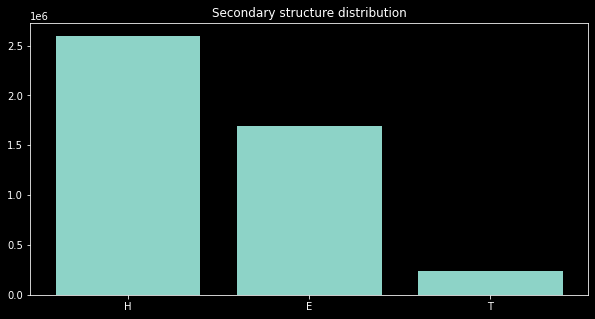

In [80]:
ss_count = {}
for ss in actual_ss:
    if ss not in ss_count:
        ss_count[ss] = 0
    else:
        ss_count[ss] += 1
print([round(c / sum(ss_count.values()), 4) for c in ss_count.values()])
mc = np.array(sorted(ss_count.items(), key=lambda x: x[1], reverse=True))
_, ax = plt.subplots(figsize=(10, 5))
ax.bar(mc[:, 0], np.array(mc[:, 1], dtype=int))
plt.title("Secondary structure distribution")
plt.show()

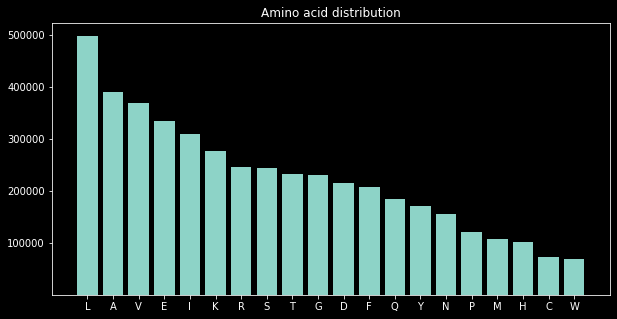

In [63]:
aa_count = {}
for aa in actual_seq:
    if aa not in aa_count:
        aa_count[aa] = 0
    else:
        aa_count[aa] += 1
mc = np.array(sorted(aa_count.items(), key=lambda x: x[1], reverse=True))
_, ax = plt.subplots(figsize=(10, 5))
plt.bar(mc[:, 0], np.array(mc[:, 1], dtype=int))
plt.ylim(ymin=100)
plt.title("Amino acid distribution")
plt.show()

[0.2417, 0.0105, 0.0772, 0.211, 0.3155, 0.1063, 0.0376, 0.0002]


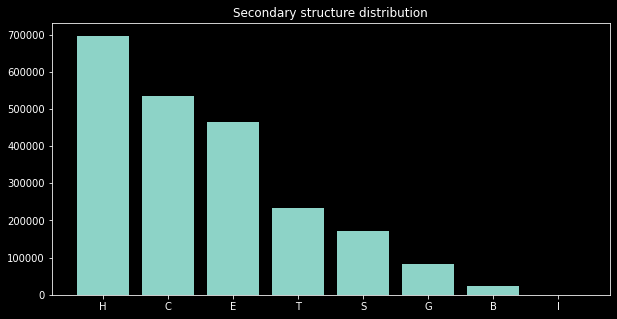

In [74]:
ss_count = {}
for ss in actual_ss:
    if ss not in ss_count:
        ss_count[ss] = 0
    else:
        ss_count[ss] += 1
print([round(c / sum(ss_count.values()), 4) for c in ss_count.values()])
mc = np.array(sorted(ss_count.items(), key=lambda x: x[1], reverse=True))
_, ax = plt.subplots(figsize=(10, 5))
ax.bar(mc[:, 0], np.array(mc[:, 1], dtype=int))
plt.title("Secondary structure distribution")
plt.show()

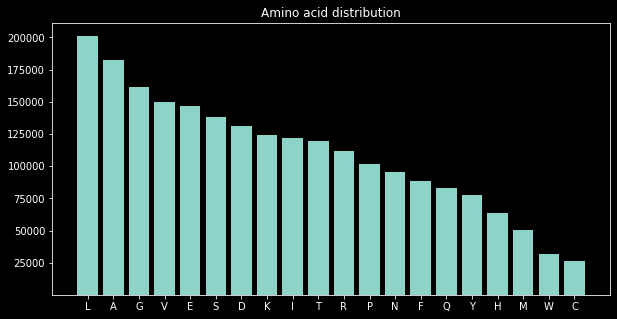

In [75]:
aa_count = {}
for aa in actual_seq:
    if aa not in aa_count:
        aa_count[aa] = 0
    else:
        aa_count[aa] += 1
mc = np.array(sorted(aa_count.items(), key=lambda x: x[1], reverse=True))
_, ax = plt.subplots(figsize=(10, 5))
plt.bar(mc[:, 0], np.array(mc[:, 1], dtype=int))
plt.ylim(ymin=100)
plt.title("Amino acid distribution")
plt.show()

In [28]:
class ProteinDataset(torch.utils.data.Dataset):
    def __init__(self, all_seq, all_ss, w_size, aa_onehot, ss_onehot_map):
        self.all_seq = all_seq
        self.all_ss = all_ss
        self.w_size = w_size
        self.aa_onehot = aa_onehot
        self.ss_onehot_map = ss_onehot_map

    def __len__(self):
        return len(self.all_seq) - self.w_size + 1

    def __getitem__(self, idx):
        seq_onehot = [self.aa_onehot[self.all_seq[aa]] for aa in range(idx, idx + self.w_size)]
        ss_onehot = self.ss_onehot_map[self.all_ss[idx + int(self.w_size / 2)]]
        return np.array(seq_onehot)[None], np.array(ss_onehot)

In [21]:
class Net(nn.Module):
    def __init__(self, height, out_size):
        super(Net, self).__init__()
        self.height = height
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn_2d_a = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn_2d_b = nn.BatchNorm2d(64)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        """
        self.rnn = nn.RNN(
            input_size=8,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
        )

        self.lstm = nn.LSTM(
            input_size=8,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
        )

        self.gru = nn.GRU(
            input_size=8,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
        )
        """

        self.fc1 = nn.Linear(64 * int((self.height - 4) / 2) * 8, 128)
        self.bn_1d_a = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn_1d_b = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, out_size)

    def forward(self, x):
        x = self.relu(self.bn_2d_a(self.conv1(x)))
        x = self.relu(self.bn_2d_b(self.conv2(x)))
        
        x = self.dropout1(self.pool(x))

        # x, h_n = self.rnn(x.view(-1, int((self.height - 4) / 2), 8), None)
        # x, h_n = self.gru(x.view(-1, int((self.height - 4) / 2), 8), None)
        # x, (h_n, h_c) = self.lstm(x.view(-1, int((self.height - 4) / 2), 8), None)
        # x = torch.flatten(x[:, -1, :], 1)
        # x = x.view(128, -1)
        
        x = torch.flatten(x, 1)
        x = self.relu(self.bn_1d_a(self.fc1(x)))
        x = self.relu(self.bn_1d_b(self.fc2(x)))
        
        x = self.fc3(self.dropout2(x))
        
        return F.log_softmax(x, dim=1)

In [22]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target.type(torch.LongTensor).cuda())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 5000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return running_loss / batch_idx

In [23]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target.type(torch.LongTensor).cuda(), reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return correct / len(test_loader.dataset)

In [29]:
w_size = 21
batch_size = 128
total_ss = 3

all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss = get_sequences("dataset/data_dump.txt", total_ss)
seq_train, seq_test, ss_train, ss_test = train_test_split(actual_seq, actual_ss, test_size=0.2, shuffle=False)

train_dataset = ProteinDataset(seq_train, ss_train, w_size, aa_onehot_map, ss_map)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataset = ProteinDataset(seq_test, ss_test, w_size, aa_onehot_map, ss_map)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(w_size, total_ss).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

loss_values = []
accuracy_values = []
test(model, device, test_loader)
for epoch in range(5):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    loss_values.append(train_loss)

    test_acc = test(model, device, test_loader)
    accuracy_values.append(test_acc)

    scheduler.step()

torch.save(model.state_dict(), "model_ss3.pth")


Test set: Average loss: 1.0570, Accuracy: 348002/906735 (38%)

Train Epoch: 1 [0/3626996 (0%)]	Loss: 1.221309
Train Epoch: 1 [640000/3626996 (18%)]	Loss: 0.724994
Train Epoch: 1 [1280000/3626996 (35%)]	Loss: 0.683890
Train Epoch: 1 [1920000/3626996 (53%)]	Loss: 0.603455
Train Epoch: 1 [2560000/3626996 (71%)]	Loss: 0.710337
Train Epoch: 1 [3200000/3626996 (88%)]	Loss: 0.705683

Test set: Average loss: 0.6540, Accuracy: 648180/906735 (71%)

Train Epoch: 2 [0/3626996 (0%)]	Loss: 0.678654
Train Epoch: 2 [640000/3626996 (18%)]	Loss: 0.651763
Train Epoch: 2 [1280000/3626996 (35%)]	Loss: 0.739825
Train Epoch: 2 [1920000/3626996 (53%)]	Loss: 0.604374
Train Epoch: 2 [2560000/3626996 (71%)]	Loss: 0.803711
Train Epoch: 2 [3200000/3626996 (88%)]	Loss: 0.733979

Test set: Average loss: 0.6440, Accuracy: 654224/906735 (72%)

Train Epoch: 3 [0/3626996 (0%)]	Loss: 0.750484
Train Epoch: 3 [640000/3626996 (18%)]	Loss: 0.722104
Train Epoch: 3 [1280000/3626996 (35%)]	Loss: 0.720676
Train Epoch: 3 [192000

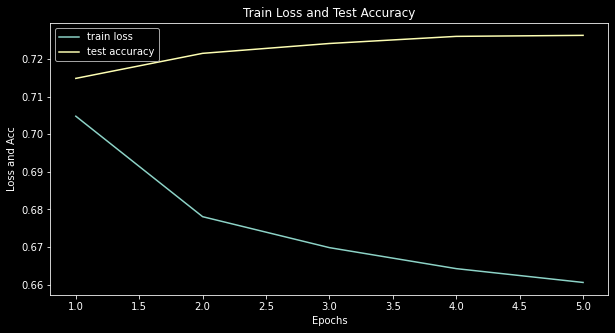

In [30]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, 6).astype(int), loss_values, label="train loss")
ax.plot(np.arange(1, 6).astype(int), accuracy_values, label="test accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss and Acc')
plt.title('Train Loss and Test Accuracy')
plt.legend()
plt.show()

In [72]:
w_size = 21
batch_size = 128
total_ss = 8

all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss = get_sequences("kaggle-pdb.csv", total_ss, csv_file=True)
seq_train, seq_test, ss_train, ss_test = train_test_split(actual_seq, actual_ss, test_size=0.2, shuffle=False)

train_dataset = ProteinDataset(seq_train, ss_train, w_size, aa_onehot_map, ss_map)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataset = ProteinDataset(seq_test, ss_test, w_size, aa_onehot_map, ss_map)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(w_size, total_ss).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

loss_values = []
accuracy_values = []
test(model, device, test_loader)
for epoch in range(5):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    loss_values.append(train_loss)

    test_acc = test(model, device, test_loader)
    accuracy_values.append(test_acc)

    scheduler.step()

torch.save(model.state_dict(), "model_ss8.pth")


Test set: Average loss: 2.1247, Accuracy: 16400/441446 (4%)

Train Epoch: 1 [0/1765842 (0%)]	Loss: 2.311855
Train Epoch: 1 [640000/1765842 (36%)]	Loss: 1.355415
Train Epoch: 1 [1280000/1765842 (72%)]	Loss: 1.330698

Test set: Average loss: 1.3355, Accuracy: 223391/441446 (51%)

Train Epoch: 2 [0/1765842 (0%)]	Loss: 1.297251
Train Epoch: 2 [640000/1765842 (36%)]	Loss: 1.271109
Train Epoch: 2 [1280000/1765842 (72%)]	Loss: 1.261168

Test set: Average loss: 1.3175, Accuracy: 227000/441446 (51%)

Train Epoch: 3 [0/1765842 (0%)]	Loss: 1.232098
Train Epoch: 3 [640000/1765842 (36%)]	Loss: 1.363202
Train Epoch: 3 [1280000/1765842 (72%)]	Loss: 1.318749

Test set: Average loss: 1.3128, Accuracy: 227575/441446 (52%)

Train Epoch: 4 [0/1765842 (0%)]	Loss: 1.336581
Train Epoch: 4 [640000/1765842 (36%)]	Loss: 1.431950
Train Epoch: 4 [1280000/1765842 (72%)]	Loss: 1.454414

Test set: Average loss: 1.3073, Accuracy: 228563/441446 (52%)

Train Epoch: 5 [0/1765842 (0%)]	Loss: 1.290258
Train Epoch: 5 [640

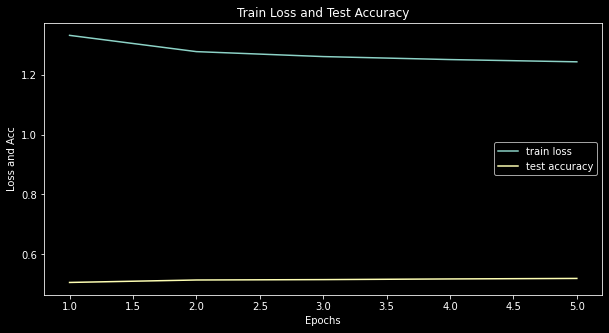

In [73]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, 6).astype(int), loss_values, label="train loss")
ax.plot(np.arange(1, 6).astype(int), accuracy_values, label="test accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss and Acc')
plt.title('Train Loss and Test Accuracy')
plt.legend()
plt.show()

In [31]:
summary(model, input_size=(1, 21, 20))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 19, 18]             320
       BatchNorm2d-2           [-1, 32, 19, 18]              64
              ReLU-3           [-1, 32, 19, 18]               0
            Conv2d-4           [-1, 64, 17, 16]          18,496
       BatchNorm2d-5           [-1, 64, 17, 16]             128
              ReLU-6           [-1, 64, 17, 16]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 128]         524,416
      BatchNorm1d-10                  [-1, 128]             256
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
      BatchNorm1d-13                   [-1, 64]             128
             ReLU-14                   

E: 1126, H: 1785, T: 161
E: 22.0, H: 29.0, T: 30.0


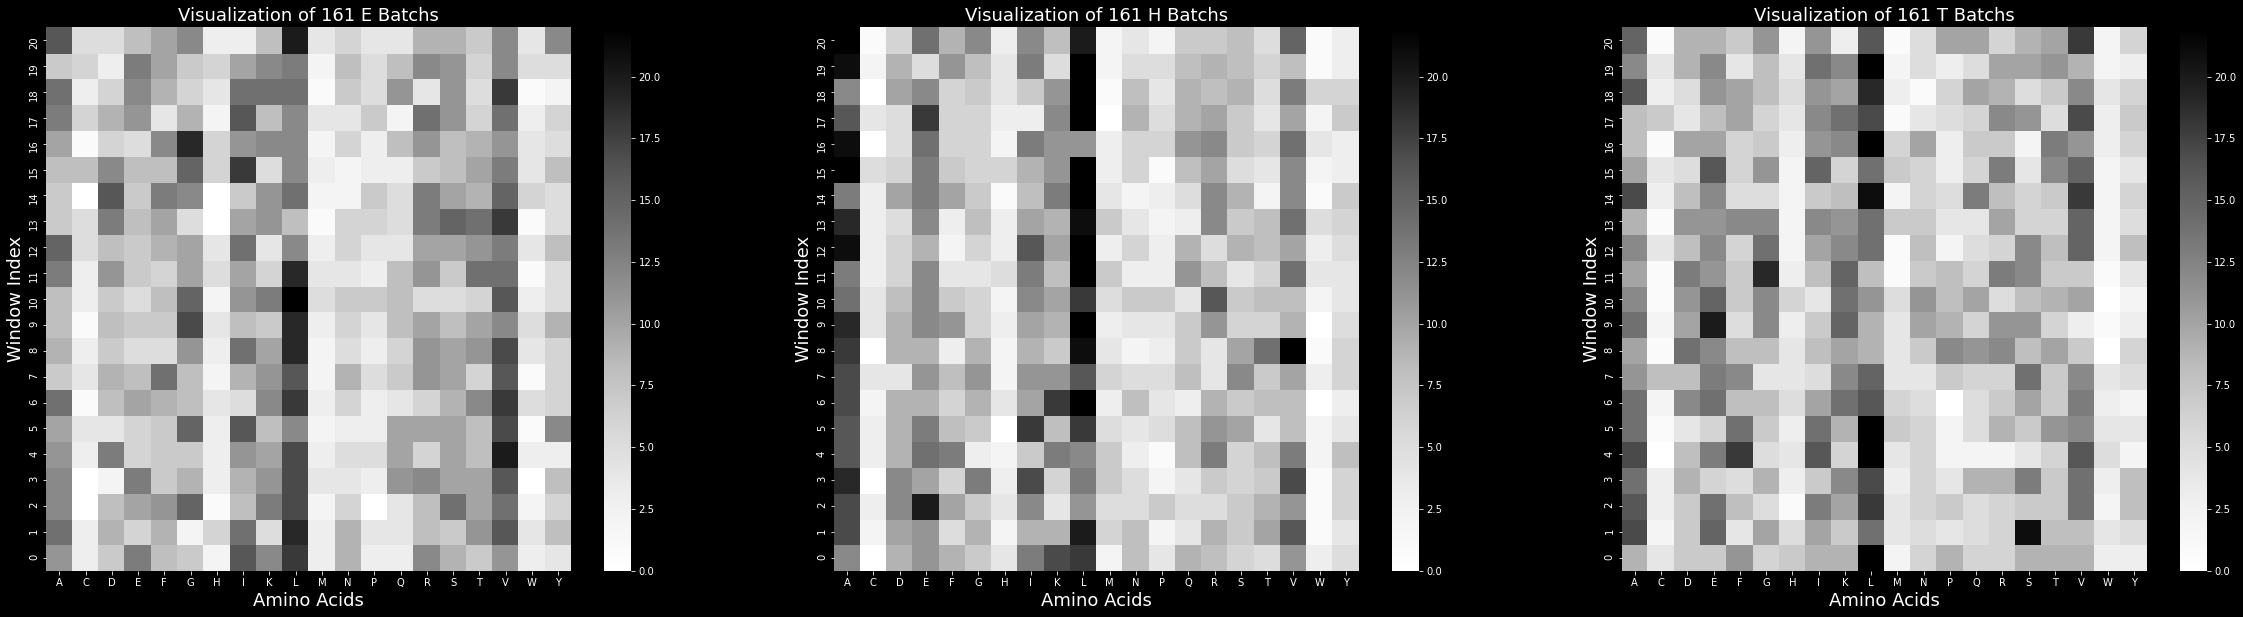

In [83]:
w_size = 21
batch_size = 512
datasets = ProteinDataset(seq_train, ss_train, w_size, aa_onehot_map, ss_map)
loader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)
next_batch_0 = next(iter(loader))
next_batch_1 = next(iter(loader))
next_batch_2 = next(iter(loader))
next_batch_3 = next(iter(loader))
next_batch_4 = next(iter(loader))
next_batch_5 = next(iter(loader))

all_next_batch_x = torch.cat((
    next_batch_0[0], next_batch_1[0], next_batch_2[0], 
    next_batch_3[0], next_batch_4[0], next_batch_5[0]
))
all_next_batch_y = torch.cat((
    next_batch_0[1], next_batch_1[1], next_batch_2[1], 
    next_batch_3[1], next_batch_4[1], next_batch_5[1]
))
all_E_table = all_next_batch_x[all_next_batch_y == 0]
all_H_table = all_next_batch_x[all_next_batch_y == 1]
all_T_table = all_next_batch_x[all_next_batch_y == 2]
print("E: {}, H: {}, T: {}".format(len(all_E_table), len(all_H_table), len(all_T_table)))

min_table = min(len(all_E_table), len(all_H_table), len(all_T_table))
all_E_table = all_E_table[:min_table]
all_H_table = all_H_table[:min_table]
all_T_table = all_T_table[:min_table]
all_E_summed = np.squeeze(all_E_table.sum(axis=0), axis=0)
all_H_summed = np.squeeze(all_H_table.sum(axis=0), axis=0)
all_T_summed = np.squeeze(all_T_table.sum(axis=0), axis=0)
print("E: {}, H: {}, T: {}".format(all_E_summed.max(), all_H_summed.max(), all_T_summed.max()))

vmax = max(all_E_summed.max(), all_H_summed.max(), all_T_summed.max())
vmax = min(all_E_summed.max(), all_H_summed.max(), all_T_summed.max())

fig, axs = plt.subplots(1, 3, figsize=(40, 10)) # 10, 30

sns.heatmap(all_E_summed, cmap="Greys", xticklabels=all_aa, ax=axs[0], vmin=0, vmax=vmax)
axs[0].set_title("Visualization of {} E Batchs".format(len(all_E_table)), fontsize=18)
axs[0].set_xlabel("Amino Acids", fontsize=18)
axs[0].set_ylabel("Window Index", fontsize=18)
axs[0].invert_yaxis()

sns.heatmap(all_H_summed, cmap="Greys", xticklabels=all_aa, ax=axs[1], vmin=0, vmax=vmax)
axs[1].set_title("Visualization of {} H Batchs".format(len(all_H_table)), fontsize=18)
axs[1].set_xlabel("Amino Acids", fontsize=18)
axs[1].set_ylabel("Window Index", fontsize=18)
axs[1].invert_yaxis()

sns.heatmap(all_T_summed, cmap="Greys", xticklabels=all_aa, ax=axs[2], vmin=0, vmax=vmax)
axs[2].set_title("Visualization of {} T Batchs".format(len(all_T_table)), fontsize=18)
axs[2].set_xlabel("Amino Acids", fontsize=18)
axs[2].set_ylabel("Window Index", fontsize=18)
axs[2].invert_yaxis()

plt.show()

torch.Size([1, 1, 21, 20])
torch.Size([21, 20])


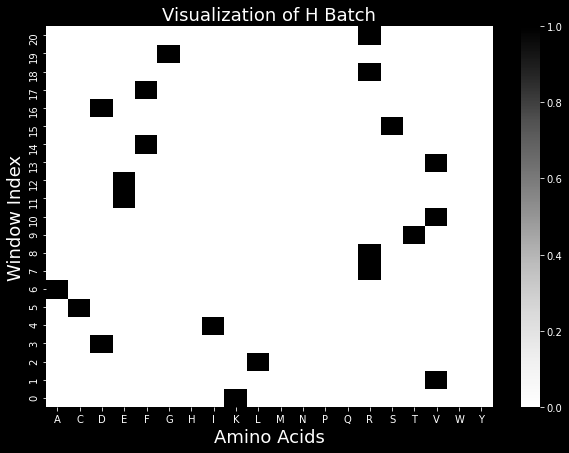

In [61]:
w_size = 21
batch_size = 1
datasets = ProteinDataset(seq_train, ss_train, w_size, aa_onehot_map, ss_map)
loader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)
temp_batch = next(iter(loader))
viz_batch = temp_batch[0]
print(viz_batch.shape)
summed = np.squeeze(viz_batch.sum(axis=0), axis=0)
print(summed.shape)
plt.figure(figsize=(10,7))
ax = sns.heatmap(summed, cmap="Greys", xticklabels=all_aa)
plt.title("Visualization of {} Batch".format(ss_map_r[temp_batch[1].item()]), fontsize=18)
plt.xlabel("Amino Acids", fontsize=18)
plt.ylabel("Window Index", fontsize=18)
plt.gca().invert_yaxis()
plt.show()